In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential
from keras.layers import *
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [18]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [19]:
cols = ['Gaze point X', 'Gaze point Y', 'Gaze point 3D X', 'Gaze point 3D Y', 'Gaze point 3D Z', 'Gaze direction left X', 'Gaze direction left Y', 'Gaze direction left Z', 'Gaze direction right X', 'Gaze direction right Y', 'Gaze direction right Z', 'Eye movement type', 'Recording timestamp']

In [20]:
sns.set(rc = {'figure.figsize':(30, 16)})
data = pd.read_csv('data.tsv', sep='\t')
data.dropna(subset=cols, inplace=True)
data.reset_index(drop=True, inplace=True)

In [21]:
# data = data[data['X'] >= 0]
# data = data[data['Y'] >= 0]
# data = data[data['X'] <= 4225]
# data = data[data['Y'] <= 1560]

data = data[cols]



for col in cols:

    if col in ['Eye movement type', 'Recording timestamp']:
        continue

    dx = np.diff(data[col])
    dy = np.diff(data['Recording timestamp'])

    data.reset_index(drop=True, inplace=True)
    data.drop(0, inplace=True)

    data[f'SPEED_DIFF_{col}'] = dx / dy


# scaler = StandardScaler()
# for col in cols:

#     if col in ['Eye movement type', 'Recording timestamp']:
#         continue
    
#     data[col] = scaler.fit_transform([data[col]])[0]



Y = pd.get_dummies(data["Eye movement type"], prefix='movement').to_numpy()
X = data.drop(['Eye movement type', 'Recording timestamp'], axis=1).to_numpy()

In [22]:
X.shape, Y.shape

((43805, 22), (43805, 3))

In [23]:
X_sequences = []
Y_sequences = []

seq_length = 3

for i in range(seq_length, len(X)):

    if i + seq_length > len(X):
        break

    X_sequences.append(X[i-seq_length:i])
    Y_sequences.append(Y[i])

In [24]:
np.shape(X_sequences), np.shape(Y_sequences)

((43800, 3, 22), (43800, 3))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, Y_sequences, test_size=0.25)

In [26]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 22))
# y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 3))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 22))
# y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 3))

np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test)

((32850, 3, 22), (32850, 3), (10950, 3, 22), (10950, 3))

In [27]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model', save_weights_only=False, monitor='val_Accuracy', mode='max', save_best_only=True, verbose=0)

In [28]:
model = Sequential()
model.add(LSTM(units=256, activation='relu', return_sequences=False, input_shape=(seq_length, 22)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=['Accuracy'])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               285696    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 286,467
Trainable params: 286,467
Non-trainable params: 0
_________________________________________________________________


In [33]:
epochs = 2000
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=50000)

Epoch 1/2000
1/1 [==============================] - 1s 571ms/step - loss: 0.3685 - Accuracy: 0.7882 - val_loss: 0.4150 - val_Accuracy: 0.7776
Epoch 2/2000
1/1 [==============================] - 0s 260ms/step - loss: 0.3557 - Accuracy: 0.7907 - val_loss: 0.4237 - val_Accuracy: 0.7714
Epoch 3/2000
1/1 [==============================] - 0s 253ms/step - loss: 0.3645 - Accuracy: 0.7871 - val_loss: 0.4306 - val_Accuracy: 0.7656
Epoch 4/2000
1/1 [==============================] - 0s 252ms/step - loss: 0.3694 - Accuracy: 0.7819 - val_loss: 0.4237 - val_Accuracy: 0.7728
Epoch 5/2000
1/1 [==============================] - 0s 250ms/step - loss: 0.3650 - Accuracy: 0.7883 - val_loss: 0.4209 - val_Accuracy: 0.7747
Epoch 6/2000
1/1 [==============================] - 0s 254ms/step - loss: 0.3639 - Accuracy: 0.7873 - val_loss: 0.4187 - val_Accuracy: 0.7732
Epoch 7/2000
1/1 [==============================] - 0s 258ms/step - loss: 0.3615 - Accuracy: 0.7855 - val_loss: 0.4166 - val_Accuracy: 0.7757
Epoch 

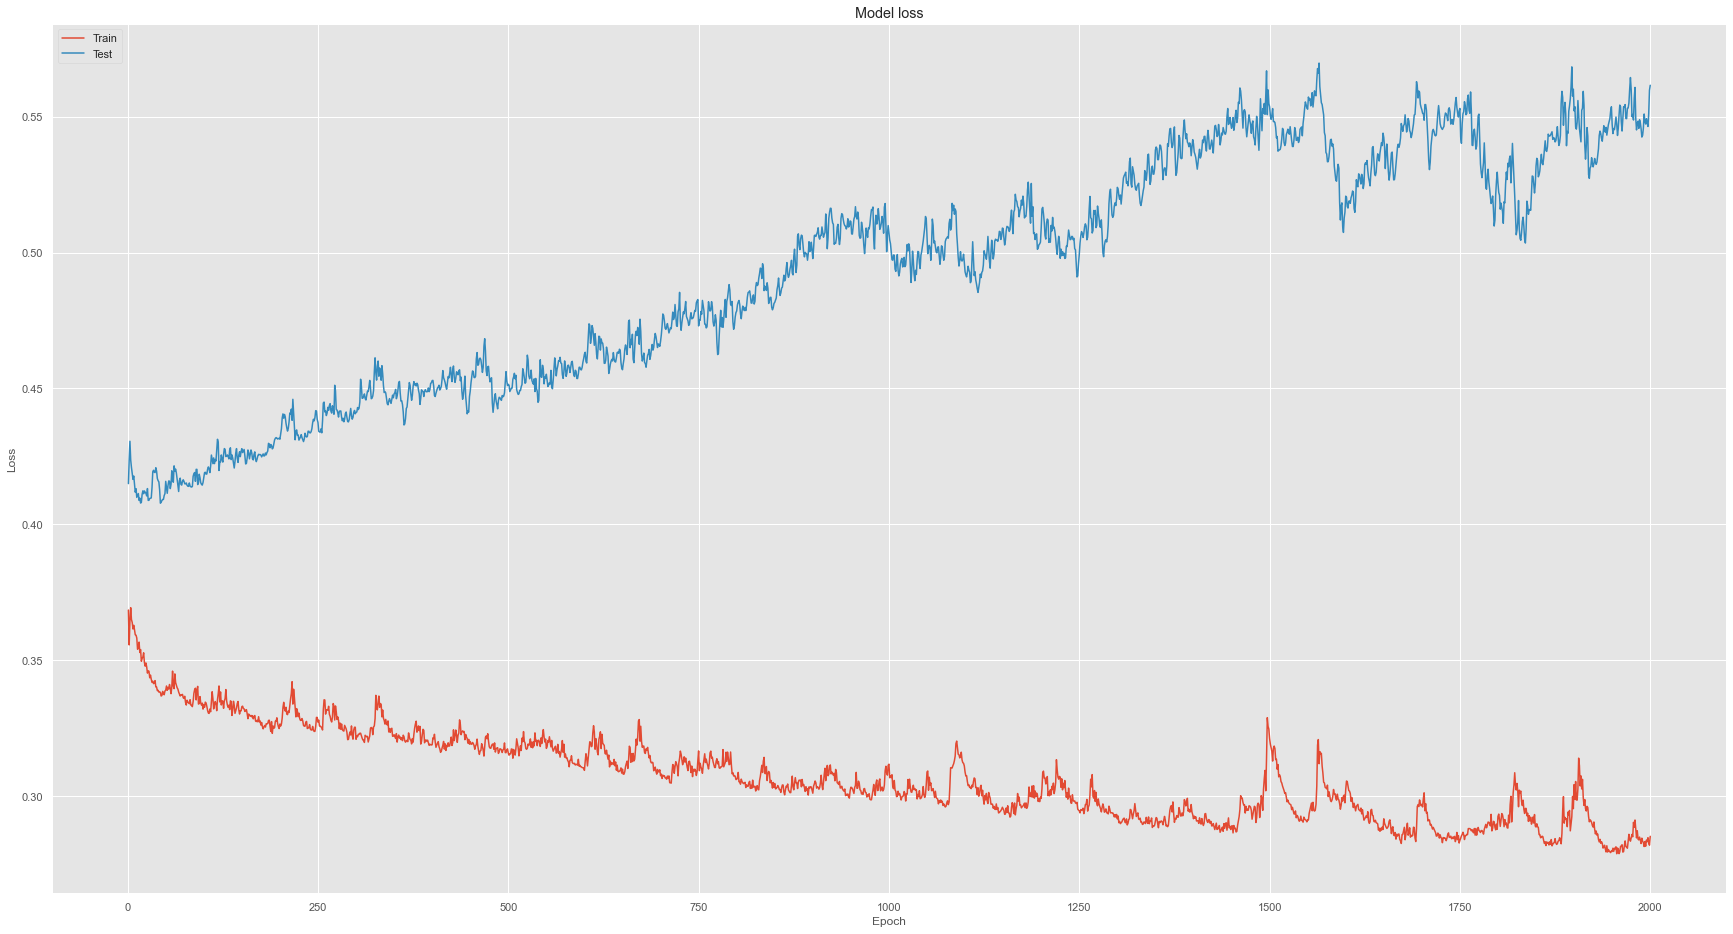

In [34]:
plt.style.use("ggplot")

plt.plot(range(1,epochs+1),
         history.history['loss'])

plt.plot(range(1,epochs+1),
         history.history['val_loss'])


plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

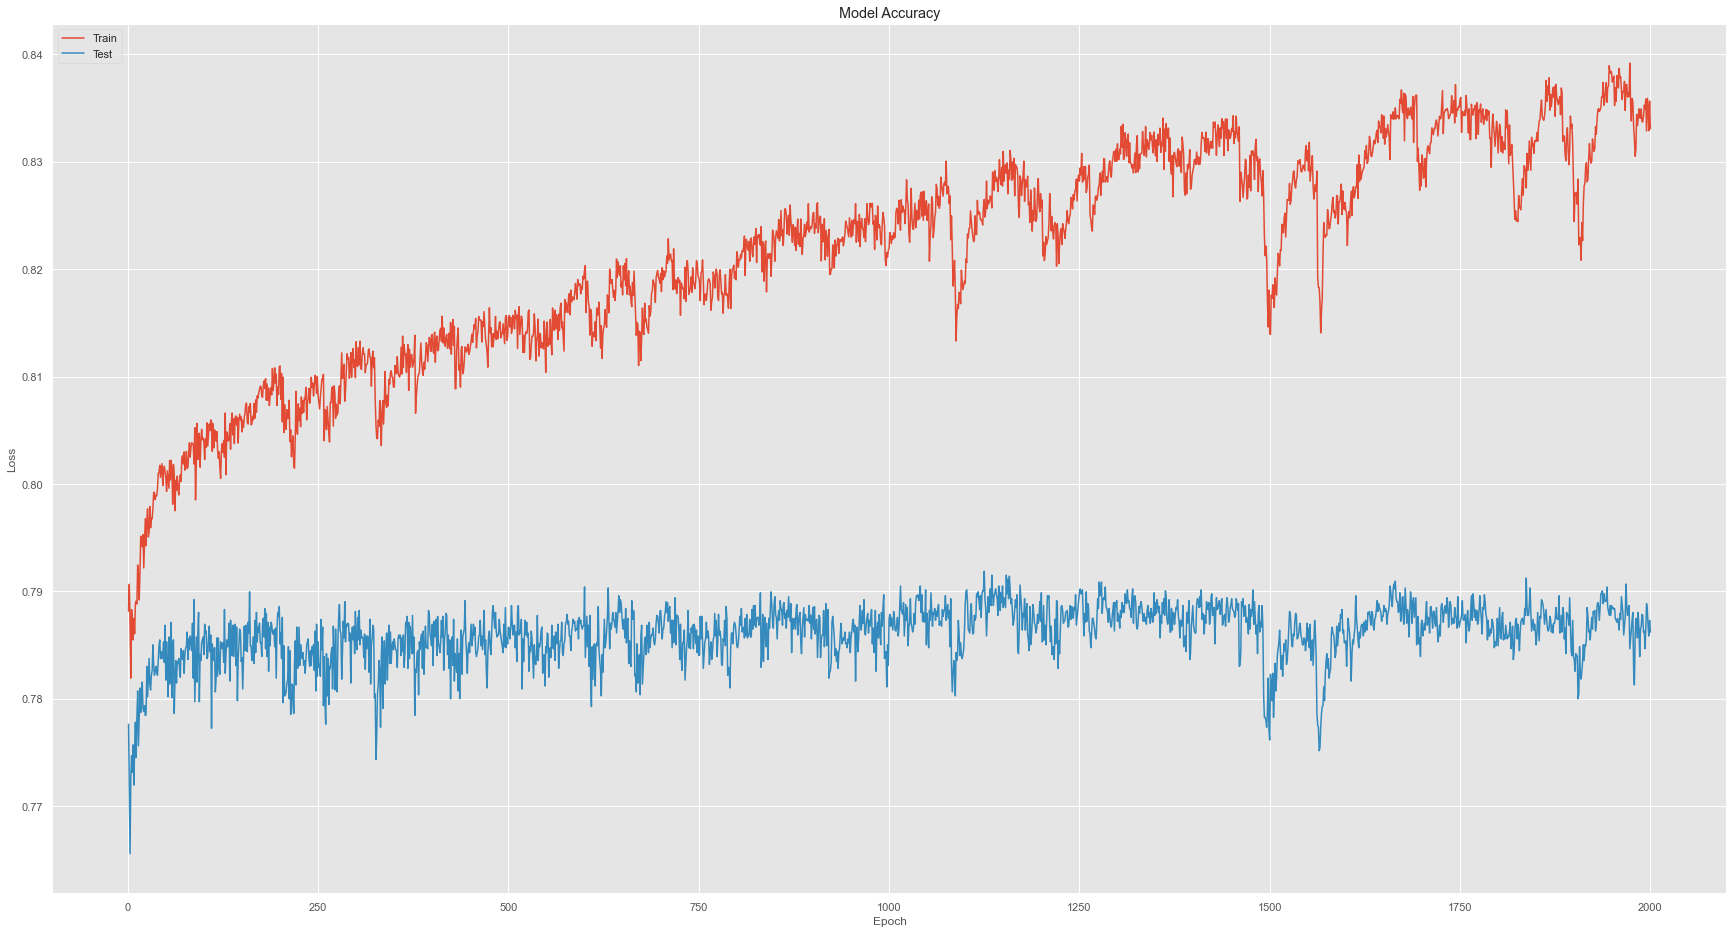

In [35]:
plt.style.use("ggplot")

plt.plot(range(1,epochs+1),
         history.history['Accuracy'])

plt.plot(range(1,epochs+1),
         history.history['val_Accuracy'])


plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()